**1. Important downloads**

This section downloads the important libraries for our model

In [ ]:
!pip install magpylib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.8/184.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0


In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
import magpylib as magpy
import matplotlib.pyplot as plt
import numpy as np
import torch as torch
import torch.nn as nn
import torch.optim as optim

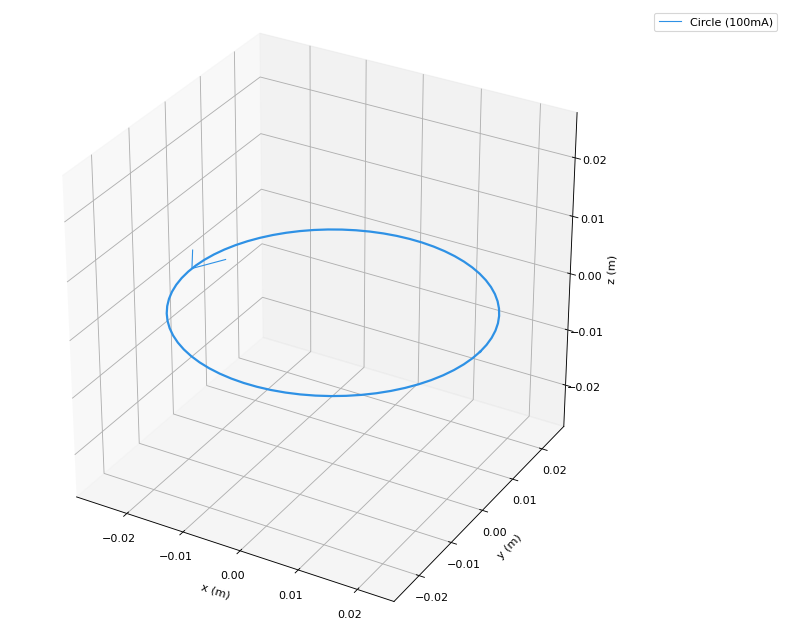

(20, 20, 3)


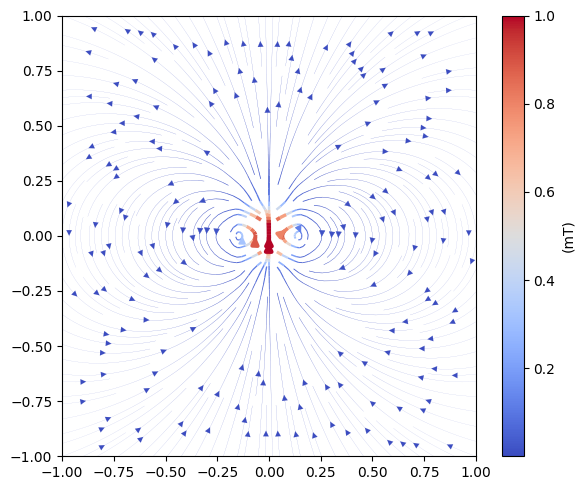

In [ ]:
#Create a single coil centered at the origin (default)
coil = magpy.current.Circle(diameter=0.05, current=0.1)
coil.show()
# Show the magnetic field around the x-z axis

fig, ax = plt.subplots(1, 1, figsize=(6,5))

# create grid
ts = np.linspace(-1, 1, 20) # 20 evenly seperated points between -1 and 1
grid = np.array([[(x,0,z) for x in ts] for z in ts])
print(grid.shape)

# normalize the magnitude of magnetic field value
B = magpy.getB(coil, grid)
Bamp = np.linalg.norm(B, axis=2)
Bamp /= np.amax(Bamp)

sp = ax.streamplot(
    grid[:,:,0], grid[:,:,2], B[:,:,0], B[:,:,2],
    density=2,
    color=Bamp,
    linewidth=np.sqrt(Bamp)*3,
    cmap='coolwarm',
)

plt.colorbar(sp.lines, ax=ax, label='(mT)')

plt.tight_layout()
plt.show()

**2. Predictions**

This section run the machine learning model with our optimized hyperparameters

In [ ]:
# This class can now specify the number of hidden layer in the neural network instead of manually creating thems
class MagneticFieldNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, numOfLayers):
        super(MagneticFieldNN, self).__init__()
        self.layers = nn.ModuleList()  # Create a ModuleList to store layers

        # Add input layer
        self.layers.append(nn.Linear(input_size, hidden_size,bias=True))
        self.layers.append(nn.ReLU())


        # Add hidden layers
        for _ in range(numOfLayers - 1):  # Subtract 1 for the input layer
            self.layers.append(nn.Linear(hidden_size, hidden_size,bias=True))
            self.layers.append(nn.ReLU())

        # Add output layer
        self.layers.append(nn.Linear(hidden_size, output_size,bias=True))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
# Class to create a magnetic source (coil)
# Diameters, currents and positions can be passed as single arguments or arrays
# If passed as arrays, equivalent of several sources
# the three arguments must have the same dimensions

class MagneticSource():
  def __init__(self,diameters, currents, positions):
    self.source = []
    try:
      iter(diameters)
      iter(currents)
      iter(positions)

      for cur, dia, pos in zip(currents, diameters, positions):
        self.source.append(magpy.current.Circle(diameter=dia, current=cur, position=pos))

    except TypeError:
      self.source = magpy.current.Circle(diameter=diameters, current=currents, position=positions)


  # get the induced magnetic field at a specific point
  def get_induced_B_field(self,points):
    try:
      iter(self.source)
      B = 0
      for coil in self.source:
        if (isinstance(coil, magpy._src.obj_classes.class_current_Circle.Circle)):
          B = B + magpy.getB(coil,points)
      return B

    except TypeError:

      return magpy.getB(self.source,points)


  def add_source(self, dia, cur, pos):
    self.source.append(magpy.current.Circle(diameter=dia, current=cur, position=pos))



In [ ]:
def compute_divergence(predicted_B, grid_points):
    """Compute the divergence of the magnetic field."""
    B_x, B_y, B_z = predicted_B[:, 0], predicted_B[:, 1], predicted_B[:, 2]

    # Compute partial derivatives using finite differences
    dB_x_dx = np.gradient(B_x, grid_points[:, 0])
    dB_y_dy = np.gradient(B_y, grid_points[:, 1])
    dB_z_dz = np.gradient(B_z, grid_points[:, 2])

    divergence = dB_x_dx + dB_y_dy + dB_z_dz
    return np.mean(np.abs(divergence))


In [ ]:
# Single magnetomotive force
# Algorithm with optimized hyperparameters
# Input data
np.random.seed(26)
numberOfSamples = 100000
current = 0.1
coil_diameter = 0.25
points = np.random.rand(numberOfSamples, 3) * 2 - 1
coil = MagneticSource(current,coil_diameter,(0,0,0))
fieldVector = coil.get_induced_B_field(points)
norms = np.linalg.norm(fieldVector, axis=1)
fieldDirection = fieldVector/norms[:, np.newaxis]
print(fieldVector[1])
print(np.linalg.norm(fieldVector[1]))
print(np.linalg.norm(fieldDirection[1]))
model = MagneticFieldNN(3,30,3,4)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00985)
Xs = torch.tensor(points, dtype=torch.float32)
Ys = torch.tensor(fieldDirection, dtype=torch.float32)

# Train set
num_epochs = 850
model.train() # Set the model in training mode
lambda_divergence = 0.0015
for epoch in range(num_epochs):
  # Forward pass
  outputs = model(Xs)

  # Compute divergence penalty
  divergence_penalty = compute_divergence(outputs.detach().numpy(), points)

  # Compute loss
  loss = criterion(outputs, Ys) + lambda_divergence * divergence_penalty
  #loss = criterion( outputs, Ys)
  if (loss <= 0.0015):
    break

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Print loss for monitoring training progress
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test set
numberOfTests = 1000
testPoints = np.random.rand(numberOfTests, 3) * 2 - 1
testVector = coil.get_induced_B_field(testPoints)
testNorms = np.linalg.norm(testVector, axis=1)
testExpected = testVector/testNorms[:, np.newaxis]

testXs = torch.tensor(testPoints, dtype=torch.float32)
testYs = torch.tensor(testExpected, dtype=torch.float32)
model.eval()


with torch.no_grad():
  testPredictions = model(testXs)





[-1.16338015e-10 -1.49057274e-10 -1.09432412e-11]
1.893999979851527e-10
1.0
Epoch [1/850], Loss: 0.3345
Epoch [2/850], Loss: 0.3276
Epoch [3/850], Loss: 0.3251
Epoch [4/850], Loss: 0.3213
Epoch [5/850], Loss: 0.3151
Epoch [6/850], Loss: 0.3064
Epoch [7/850], Loss: 0.2957
Epoch [8/850], Loss: 0.2824
Epoch [9/850], Loss: 0.2666
Epoch [10/850], Loss: 0.2496
Epoch [11/850], Loss: 0.2320
Epoch [12/850], Loss: 0.2168
Epoch [13/850], Loss: 0.2085
Epoch [14/850], Loss: 0.2078
Epoch [15/850], Loss: 0.2098
Epoch [16/850], Loss: 0.2079
Epoch [17/850], Loss: 0.1965
Epoch [18/850], Loss: 0.1741
Epoch [19/850], Loss: 0.1499
Epoch [20/850], Loss: 0.1278
Epoch [21/850], Loss: 0.1133
Epoch [22/850], Loss: 0.1053
Epoch [23/850], Loss: 0.1062
Epoch [24/850], Loss: 0.1125
Epoch [25/850], Loss: 0.1183
Epoch [26/850], Loss: 0.1194
Epoch [27/850], Loss: 0.1165
Epoch [28/850], Loss: 0.1126
Epoch [29/850], Loss: 0.1110
Epoch [30/850], Loss: 0.1127
Epoch [31/850], Loss: 0.1155
Epoch [32/850], Loss: 0.1176
Epoch

[47.7 76.6 84.5 87.6 89.8]


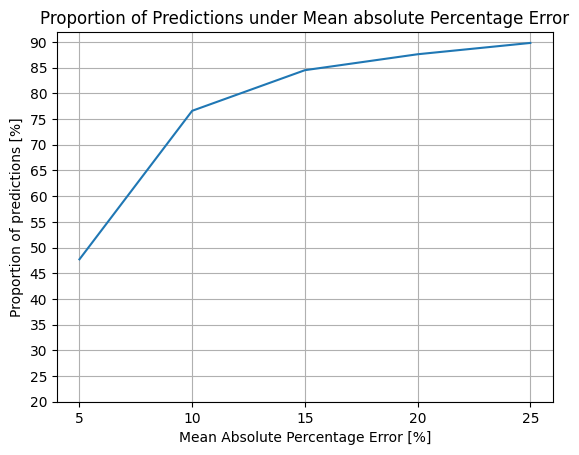

In [ ]:
# Test accuracy
meanTestYs = torch.mean(testYs)

tss = torch.sum((testYs - meanTestYs)**2)


rss = torch.sum((testYs - testPredictions)**2)


rSquared = 1 - (rss / tss)
absolutePercentageError = np.abs((testExpected - testPredictions.numpy()) / testExpected) * 100
absolutePercentageError[np.isnan(absolutePercentageError)] = 0
mape = np.mean(absolutePercentageError, axis=1)

errorPercentage = np.arange(5, 26, 5)
NbUnderPercentage = np.array([np.sum(mape <= x) for x in errorPercentage])

#print(f'mape: {mape}')
plt.plot(errorPercentage, NbUnderPercentage/numberOfTests * 100)
print(NbUnderPercentage/numberOfTests * 100)
plt.xticks(errorPercentage)
plt.yticks(np.arange(20, 91, 5))

plt.xlabel('Mean Absolute Percentage Error [%]')
plt.ylabel('Proportion of predictions [%]')
plt.title('Proportion of Predictions under Mean absolute Percentage Error')

plt.grid(True)

plt.show()


In [ ]:
# #Create a two coils centered at the origin (default)
# coil1 = magpy.current.Circle(diameter=0.05, current=0.1, position=(0,0,0))
# coil2 = magpy.current.Circle(diameter=0.12, current=0.15, position=(0.2,0.2,0.2))
# magnetic_source = {"s1": coil1, "s2" : coil2}
# magpy.show(*magnetic_source.values())

In [ ]:
# Save the weights of the training
parameters = list(model.parameters())
weights = [param for param in parameters if len(param.shape) > 1]
for i, weight in enumerate(weights):
    print(f"Weight {i + 1}:")
    print(weight.shape)
print(np.linalg.norm(testPredictions, axis=1))

This section tests the effect of different hyperparameter values on the overall accuracy. **Don't run this section !!!!**

In [ ]:
# Single magnetomotive force
# Algorithm with optimized hyperparameters
numberOfSamples = 100000
coil_diameter = 0.05
points = np.random.rand(numberOfSamples, 3) * 2 - 1
coil = MagneticSource(0.1,coil_diameter,(0,0,0))
fieldVector = coil.get_induced_B_field(points)
norms = np.linalg.norm(fieldVector, axis=1)
fieldDirection = fieldVector/norms[:, np.newaxis]
print(fieldVector[1])
print(np.linalg.norm(fieldVector[1]))
print(np.linalg.norm(fieldDirection[1]))


learning_rates = [0.00955,0.00970,0.00985,0.01,0.0115]
lambdas = [0.0005,0.0010,0.0015,0.0020,0.0025]
hidden_sizes = [5,10,20,26,30]
number_hidden_layers = [2,3,4,5,6]
testPredictions_list = []
testYs_list = []
for lbda in lambdas:
    model = MagneticFieldNN(3,26,3,4)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00985)
    Xs = torch.tensor(points, dtype=torch.float32)
    Ys = torch.tensor(fieldDirection, dtype=torch.float32)

    # Train set
    num_epochs = 850
    model.train() # Set the model in training mode
    lambda_divergence = lbda
    for epoch in range(num_epochs):
      # Forward pass
      outputs = model(Xs)

      # Compute divergence penalty
      divergence_penalty = compute_divergence(outputs.detach().numpy(), points)

      # Compute loss
      loss = criterion(outputs, Ys) + lambda_divergence * divergence_penalty
      #loss = criterion( outputs, Ys)
      if (loss <= 0.0015):
        break

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Print loss for monitoring training progress
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Test set
    numberOfTests = 1000
    testPoints = np.random.rand(numberOfTests, 3) * 2 - 1
    testVector = coil.get_induced_B_field(testPoints)
    testNorms = np.linalg.norm(testVector, axis=1)
    testExpected = testVector/testNorms[:, np.newaxis]

    testXs = torch.tensor(testPoints, dtype=torch.float32)
    testYs_list.append(torch.tensor(testExpected, dtype=torch.float32))
    model.eval()


    with torch.no_grad():
      testPredictions_list.append(model(testXs))

In [ ]:
for lmbda,testYs,testPredictions in zip(lambdas,testYs_list,testPredictions_list):

  # Test accuracy
  meanTestYs = torch.mean(testYs)

  tss = torch.sum((testYs - meanTestYs)**2)


  rss = torch.sum((testYs - testPredictions)**2)


  rSquared = 1 - (rss / tss)
  absolutePercentageError = np.abs((testExpected - testPredictions.numpy()) / testExpected) * 100
  absolutePercentageError[np.isnan(absolutePercentageError)] = 0
  mape = np.mean(absolutePercentageError, axis=1)

  errorPercentage = np.arange(5, 26, 5)
  NbUnderPercentage = np.array([np.sum(mape <= x) for x in errorPercentage])

  #print(f'mape: {mape}')
  plt.plot(errorPercentage, NbUnderPercentage/numberOfTests * 100)

  plt.xticks(errorPercentage)
  print(lmbda)
  print(errorPercentage)
  print(NbUnderPercentage/numberOfTests * 100)
  plt.yticks(np.arange(20, 91, 5))

  plt.xlabel('Mean Absolute Percentage Error [%]')
  plt.ylabel('Proportion of predictions [%]')
  plt.title('Proportion of Predictions under Mean absolute Percentage Error')

  plt.grid(True)

  plt.show()


**Do not run the following cells!!!!!**

It was designed to find the optimal hyperparameters based on an algorithm.
It takes a long time to run so we only ran it once to find our hyperparameters

In [ ]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

In [ ]:
# Find optimal hyperparameters

numberOfSamples = 100000
points = np.random.rand(numberOfSamples, 3) * 2 - 1
fieldVector = magpy.getB(coil, points)

# direction
norms = np.linalg.norm(fieldVector, axis=1)
fieldDirection = fieldVector / norms[:, np.newaxis]

#for n in numberOfHiddenLayers:
@use_named_args([Real(0.001, 0.01, name='learning_rate'),
                 Integer(1, 8, name='num_hidden_layers'),
                 Integer(5, 30, name='size_hidden_layers')])
def objective(learning_rate, num_hidden_layers, size_hidden_layers):
  model = MagneticFieldNN(3,size_hidden_layers,3,num_hidden_layers)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  Xs = torch.tensor(points, dtype=torch.float32)
  Ys = torch.tensor(fieldDirection, dtype=torch.float32)


  # Train set
  num_epochs = 2500
  model.train() # Set the model in training mode
  for epoch in range(num_epochs):
    # Forward pass
    outputs = model(Xs)
    loss = criterion(outputs, Ys)
    if (loss <= 0.0015):
      break

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print("+1")

  # Test set
  numberOfTests = 1000
  testPoints = np.random.rand(numberOfTests, 3) * 2 - 1
  testVector = magpy.getB(coil, testPoints)
  testNorms = np.linalg.norm(testVector, axis=1)
  testExpected = testVector / testNorms[:, np.newaxis]

  testXs = torch.tensor(testPoints, dtype=torch.float32)
  testYs = torch.tensor(testExpected, dtype=torch.float32)
  model.eval()


  with torch.no_grad():
    testPredictions = model(testXs)

  meanTestYs = torch.mean(testYs)

  tss = torch.sum((testYs - meanTestYs)**2)

  rss = torch.sum((testYs - testPredictions)**2)

  rSquared = 1 - (rss / tss)
  absolutePercentageError = np.abs((testExpected - testPredictions.numpy()) / testExpected) * 100
  absolutePercentageError[np.isnan(absolutePercentageError)] = 0
  mape = np.mean(absolutePercentageError, axis=1)
  errorPercentage = 15
  NbOverPercentage = np.sum(mape >= errorPercentage)

  return NbOverPercentage

space = [Real(0.001, 0.01, name='learning_rate'),
         Integer(1, 8, name='num_hidden_layers'),
         Integer(5, 30, name='size_hidden_layers')]
result = gp_minimize(objective, space, n_calls=10, random_state=42)
best_params = result.x
best_objective = result.fun
print("Best hyperparameters:", best_params)
print("Best objective:", best_objective)





+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
Best hyperparameters: [0.009849077972261096, 4, 26]
Best objective: 206
